mass ratio is  0.788218840254 +/- 0.089295877228
Periodogram peaks above a power of  0.25 :  [ 2.43340841  2.61357858  2.66762963  2.72168068  2.88383383  2.93788488
  3.20814014  3.29822522  3.64054855  3.73063363  3.94683784  4.28916116
  4.41528028  4.59545045  5.04587588  5.26208008  5.47828428  5.89267568
  6.18094795  6.46922022  7.47817317  7.91058158  8.36100701]


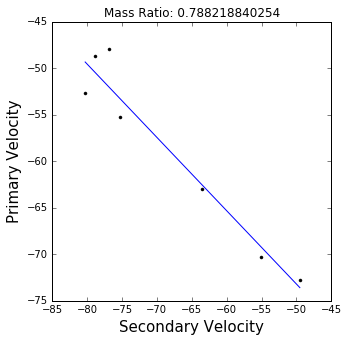

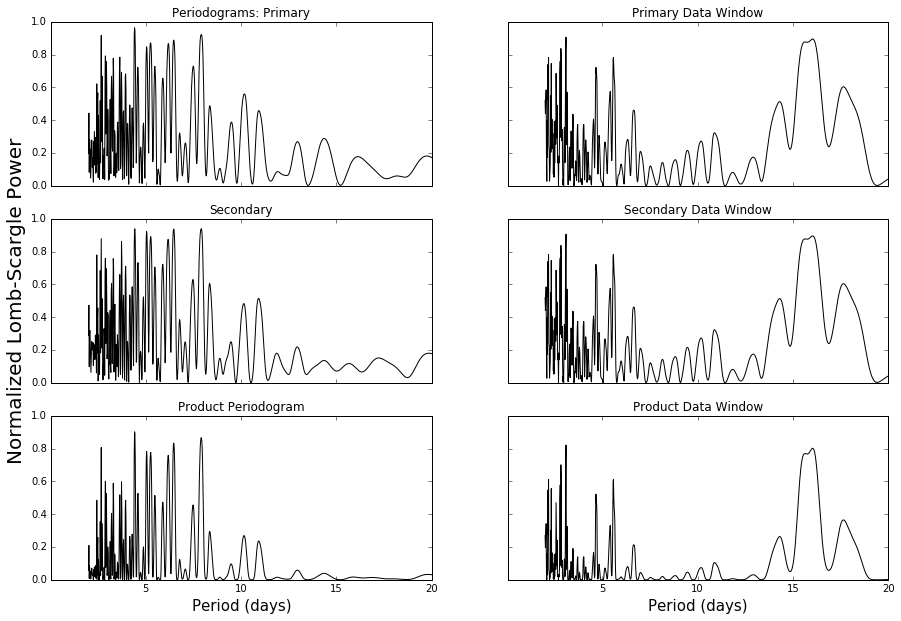

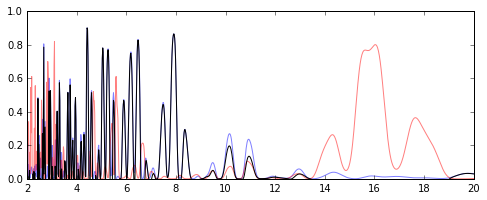

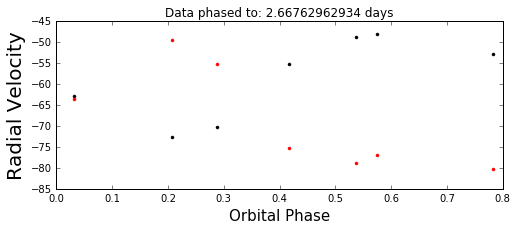

In [1]:
#import-libraries-and-data---------------------------------------------------------------------------------------#
import time
t0 = time.time()
import corner
import numpy as np
import functions as f
from matplotlib import pyplot as plt
%matplotlib inline
filename     = 'Systems/2M03450783+3102335/2M03450783+3102335.tbl'
system       = np.genfromtxt(filename, skip_header=1, usecols=(0, 1, 2))#, max_rows=11)

#define-variables------------------------------------------------------------------------------------------------#

JD, RVp, RVs = [datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs     = JD, JD
samples      = 1000
max_period   = 20
power_cutoff = 0.25
nwalkers, nsteps = 400, 10000

#define-functions------------------------------------------------------------------------------------------------#

periodogram     = f.periodogram
dataWindow      = f.dataWindow
maxima          = f.maxima
phases          = f.phases
massRatio       = f.massRatio
adjustment      = f.adjustment
RV              = f.RV
residuals       = f.residuals
constraints     = f.constraints
MCMC            = f.MCMC
rSquared        = f.rSquared

#now-do-things!--------------------------------------------------------------------------------------------------#

#Secondary v Primary plot (mass ratio)
mass_ratio, intercept, r_squared, standard_error, slope_error = massRatio(RVs,RVp, system)
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.plot(RVs, RVp, 'k.')
ax.set_title('Mass Ratio: %s'%(mass_ratio))
x, y = np.array([np.nanmin(RVs), np.nanmax(RVs)]), -mass_ratio*np.array([np.nanmin(RVs), 
                                                                        np.nanmax(RVs)])+intercept
ax.plot(x, y)
ax.set_ylabel('Primary Velocity', size='15')
ax.set_xlabel('Secondary Velocity', size='15')
#plt.savefig(filename + ' Mass Ratio.png')
print('mass ratio is ', mass_ratio, "+/-", standard_error)

#check RV measurements for the need to be adjusted and adjust them if so
JDp, RVp = adjustment(JD, RVp)
JDs, RVs = adjustment(JD, RVs)

#calculate periodograms
x, y  = periodogram(JDp, RVp, samples, max_period)
y2    = periodogram(JDs, RVs, samples, max_period)[1]
y3,y4 = dataWindow(JDp, samples, max_period)[1], dataWindow(JDs, samples, max_period)[1]

#plot periodograms
fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, sharex='col', sharey='row')
ax1.plot(x, y, 'k')
ax1.set_title('Periodograms: Primary')
ax1.set_xlim(1/24, max_period)
ax4.set_xlim(1/24, max_period)
ax2.plot(x, y2, 'k')
ax2.set_title('Secondary')
ax3.plot(x, y*y2, 'k')
ax3.set_title('Product Periodogram')
ax4.plot(x, y3, 'k')
ax4.set_title('Primary Data Window')
ax5.plot(x, y4, 'k')
ax5.set_title('Secondary Data Window')
ax6.plot(x, y3*y4, 'k')
ax6.set_title('Product Data Window')
ax3.set_xlabel('Period (days)', size='15')
ax6.set_xlabel('Period (days)', size='15')
ax2.set_ylabel('Normalized Lomb-Scargle Power', size='20')
fig.set_figheight(10)
fig.set_figwidth(15)
#plt.savefig(filename + ' periodogram.png')
print('Periodogram peaks above a power of ', power_cutoff, ': ', maxima(power_cutoff, x, y*y2-y3*y4))

#plot periodogram - data window
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
ax.plot(x, y*y2, 'b', alpha = 0.5)
ax.plot(x, y3*y4, 'r', alpha = 0.5)
ax.plot(x, y*y2-y3*y4, 'k', alpha = 1)
ax.set_ylim(0,1)
ax.set_title('')
#plt.savefig(filename + ' adjusted periodogram.png')

#plot phased RVs
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
ax.plot(phases(maxima(power_cutoff, x, y*y2-y3*y4)[2], JDp), RVp, 'k.')
ax.plot(phases(maxima(power_cutoff, x, y*y2-y3*y4)[2], JDs), RVs, 'r.')
ax.set_title('Data phased to: %s days'%(maxima(power_cutoff, x, y*y2-y3*y4)[2]))
ax.set_xlabel('Orbital Phase', size='15')
ax.set_ylabel('Radial Velocity', size='20')
#plt.savefig(filename + ' RV-phase diagram.png')

/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater


[[  4.46481775e+01   9.20321702e+00   7.44319070e+00]
 [  8.33562224e-01   1.16934017e-01   5.30388330e-02]
 [  3.04598351e+00   1.08736409e+00   5.18055850e-01]
 [  2.45663335e+06   1.59308783e+00   1.84009894e+00]
 [  7.86442438e+00   9.71941081e-01   4.64088101e-01]
 [ -6.25917696e+01   2.87867438e+00   1.31450826e+00]]
Completed in  3  minutes and  42 seconds.


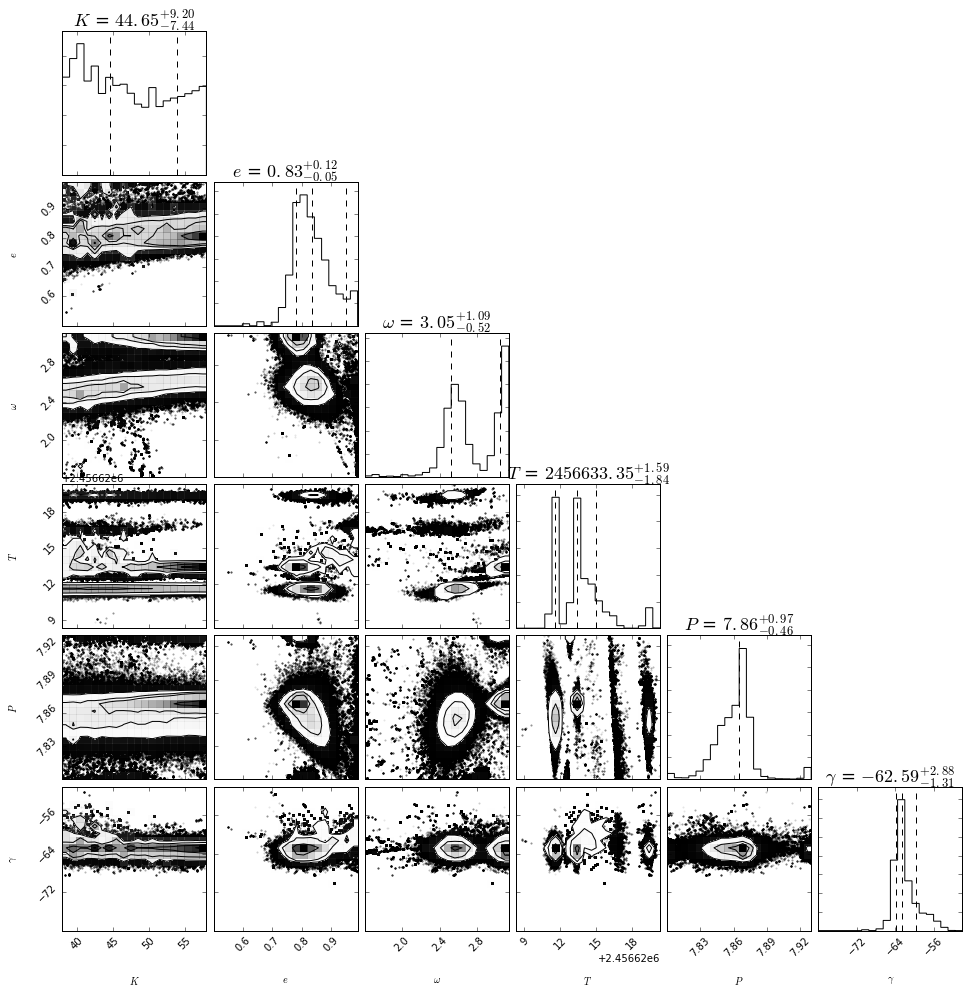

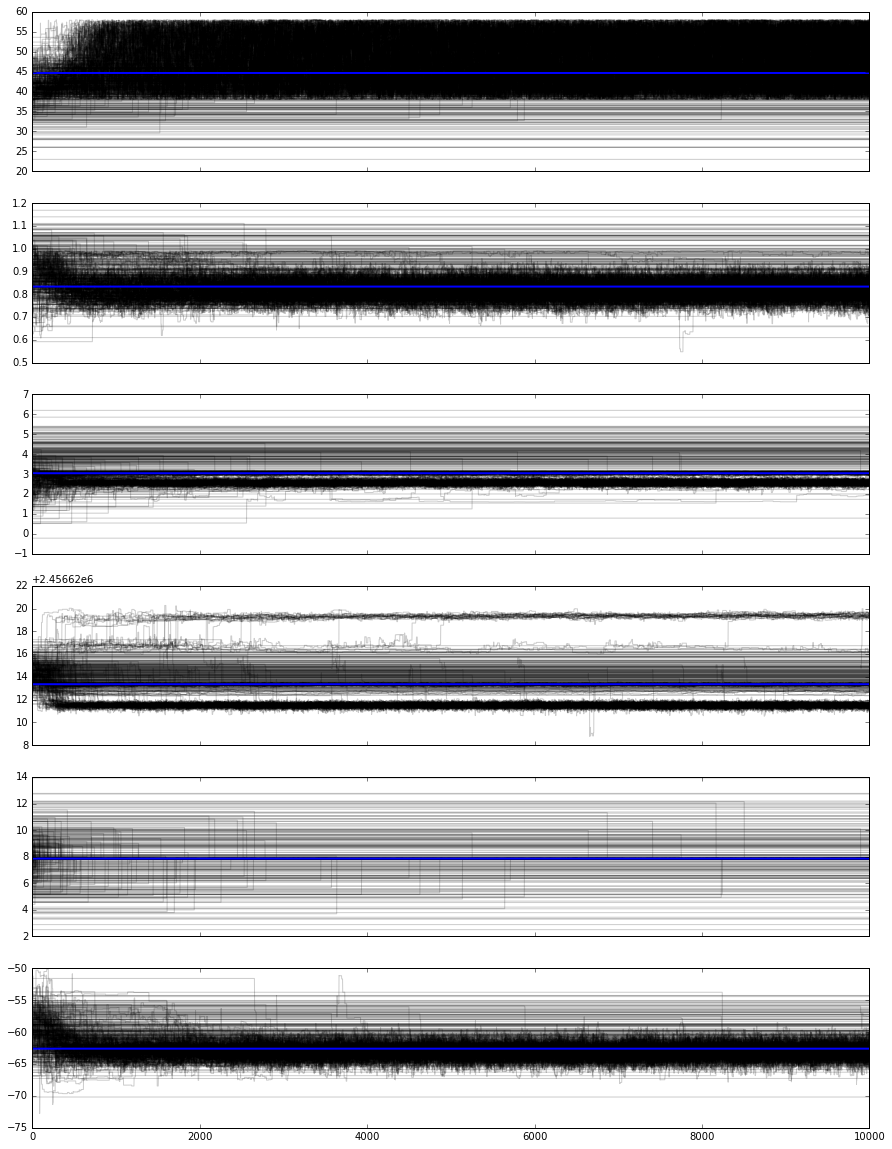

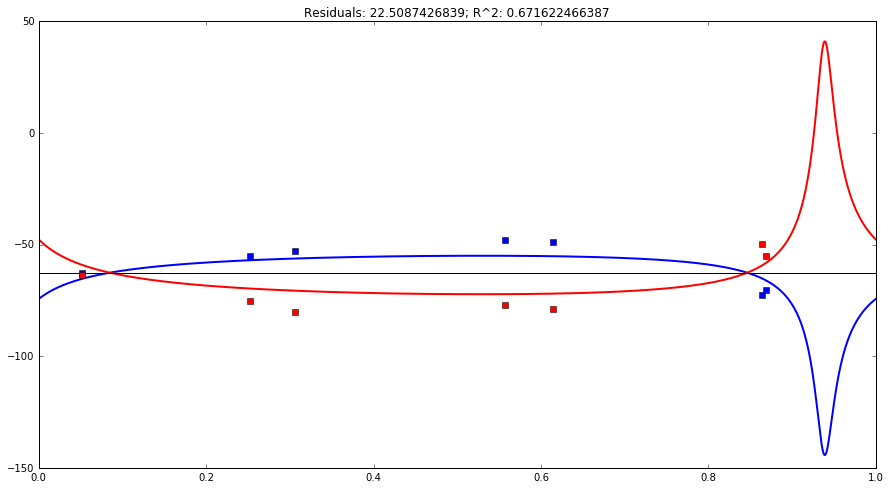

In [2]:
#constrain parameters
lower_bounds = [38, 0.5, 1.6, JD[0]+((JD[-1]-JD[0])/2)-0.75*8, 7.8, -80]
upper_bounds = [58, 0.99, np.pi, JD[0]+((JD[-1]-JD[0])/2)+0.75*8, 7.93, -50]

#take a walk
sampler = MCMC(mass_ratio, RVp, RVs, JDp, JDs, lower_bounds, upper_bounds, 6, nwalkers, nsteps, 4)

#save the results of the walk
samples = sampler.chain[:, 1000:, :].reshape((-1, 6))
results = np.asarray(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              zip(*np.percentile(samples, [16, 50, 84], axis=0)))))
parameters = [results[i][0] for i in range(0, 6)]

#create the corner plot
fig = corner.corner(samples,labels=['$K$','$e$','$\omega$','$T$','$P$','$\gamma$'],
                    range=  [[lower_bounds[0],upper_bounds[0]],
                             [lower_bounds[1],upper_bounds[1]],
                             [lower_bounds[2],upper_bounds[2]],
                             [lower_bounds[3],upper_bounds[3]],
                             [lower_bounds[4],upper_bounds[4]],
                             [lower_bounds[5],upper_bounds[5]]],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})
plt.savefig(filename + ' parameter_results.png')

#create the walkers plot
fig, ax = plt.subplots(6, 1, sharex='col')
for i in range(6):
    for j in range(len(sampler.chain[:, 0, i])):
        ax[i].plot(np.linspace(0, nsteps, num=nsteps), sampler.chain[j, :, i], 'k', alpha=0.2)
    ax[i].plot(np.linspace(0, nsteps, num=nsteps) , np.ones(nsteps)*results[i][0], 'b', lw=2)
fig.set_figheight(20)
fig.set_figwidth(15)
plt.savefig(filename + ' walk_results.png')

#create the curves plot
x = np.linspace(0, 15.8, num=nsteps)
fig, ax = plt.figure(figsize=(15,8)), plt.subplot(111)
primary, secondary = RV(x, mass_ratio, [results[0][0], results[1][0], results[2][0],
                                        results[3][0], results[4][0], results[5][0]])
ax.plot(x/results[4][0], primary, 'b', lw=2)
ax.plot(x/results[4][0], secondary, 'r', lw=2)
ax.plot(x, np.ones(len(x))*results[5][0], 'k' , label='Systemic Velocity')
ax.plot(phases(results[4][0], JDp), RVp, 'bs', label='Primary RV Data') #data phased to result period
ax.plot(phases(results[4][0], JDs), RVs, 'rs', label='Secondary RV data')
ax.set_xlim([0,1])
ax.set_title('Residuals: %s; R^2: %s'%(residuals(parameters, mass_ratio, RVp, RVs, JDp, JDs), rSquared(parameters, mass_ratio, RVp, RVs, JDp, JDs)))
plt.savefig(filename + ' curve_results.png')

#print('Results:')
#for i in range(len(initial_guess)):
#    print(results[i][0], '+',results[i][1], '-',results[i][2])
#t = time.time()
#print('Completed in ', int((t-t0)/60), ' minutes and ', int(((t-t0)/60-int((t-t0)/60))*60), 'seconds.')
print(results)
t = time.time()
print('Completed in ', int((t-t0)/60), ' minutes and ', int(((t-t0)/60-int((t-t0)/60))*60), 'seconds.')

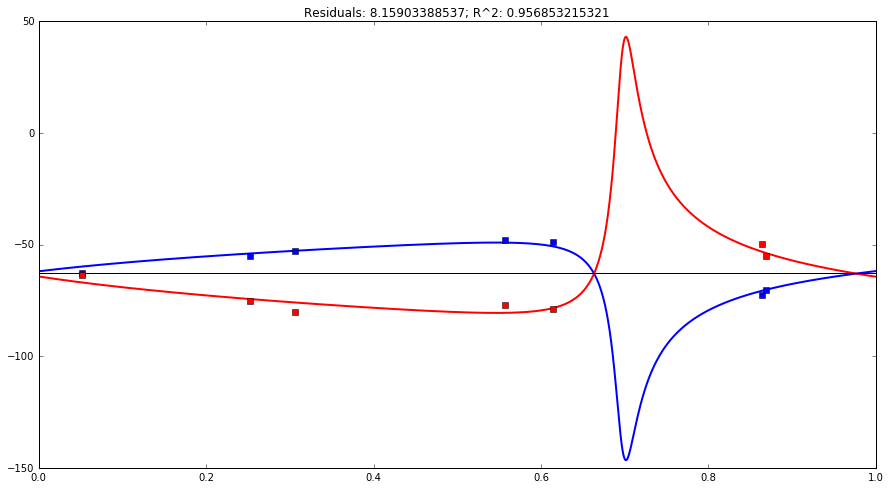

In [8]:
#create the curves plot
x = np.linspace(0, 15.8, num=nsteps)
fig, ax = plt.figure(figsize=(15,8)), plt.subplot(111)
primary, secondary = RV(x, mass_ratio, [48.75, 0.82, 2.63, 2456631.58, 7.85, -62.98])
ax.plot(x/results[4][0], primary, 'b', lw=2)
ax.plot(x/results[4][0], secondary, 'r', lw=2)
ax.plot(x, np.ones(len(x))*results[5][0], 'k' , label='Systemic Velocity')
ax.plot(phases(results[4][0], JDp), RVp, 'bs', label='Primary RV Data') #data phased to result period
ax.plot(phases(results[4][0], JDs), RVs, 'rs', label='Secondary RV data')
ax.set_xlim([0,1])
ax.set_title('Residuals: %s; R^2: %s'%(residuals([48.75, 0.82, 2.63, 2456631.58, 7.85, -62.98], mass_ratio, RVp, RVs, JDp, JDs), rSquared([48.75, 0.82, 2.63, 2456631.58, 7.85, -62.98], mass_ratio, RVp, RVs, JDp, JDs)))
plt.savefig(filename + ' curve_results.png')

In [3]:
'''#take a walk
sampler = MCMC(mass_ratio, RVp, RVs, JDp, JDs, lower_bounds, upper_bounds, 4, nwalkers, nsteps, 4)

#save the results of the walk
circular_samples = sampler.chain[:, 1000:, :].reshape((-1, 4))
results = np.asarray(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              zip(*np.percentile(circular_samples, [16, 50, 84], axis=0)))))
parameters = [results[i][0] for i in range(0, 4)]

#create the corner plot
fig = corner.corner(circular_samples,labels=["$K$","$T$","$P$","$\gamma$"],
                    range=  [[lower_bounds[0],upper_bounds[0]],
                             [lower_bounds[1],upper_bounds[1]],
                             [lower_bounds[2],upper_bounds[2]],
                             [lower_bounds[3],upper_bounds[3]]],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})
plt.savefig(filename + ' no e parameter_results.png')

#create the walkers plot
fig, ax = plt.subplots(4, 1, sharex='col')
for i in range(4):
    for j in range(len(sampler.chain[:, 0, i])):
        ax[i].plot(np.linspace(0, nsteps, num=nsteps), sampler.chain[j, :, i], 'k', alpha=0.2)
    ax[i].plot(np.linspace(0, nsteps, num=nsteps) , np.ones(nsteps)*results[i][0], 'b', lw=2)
fig.set_figheight(20)
fig.set_figwidth(15)
plt.savefig(filename + ' no e walk_results.png')

#create the curves plot
x = np.linspace(0, 15.8, num=nsteps)
fig, ax = plt.figure(figsize=(15,8)), plt.subplot(111)
primary, secondary = RV(x, mass_ratio, [results[0][0], results[1][0], results[2][0], results[3][0]])
ax.plot(x/results[2][0], primary, 'b', lw=2)
ax.plot(x/results[2][0], secondary, 'r', lw=2)
ax.plot(x, np.ones(len(x))*results[3][0], 'k' , label='Systemic Velocity')
ax.plot(phases(results[2][0], JDp), RVp, 'bs', label='Primary RV Data') #data phased to result period
ax.plot(phases(results[2][0], JDs), RVs, 'rs', label='Secondary RV data')
ax.set_xlim([0,1])
ax.set_title('Residuals: %s; R^2: %s'%(residuals(parameters, mass_ratio, RVp, RVs, JDp, JDs), rSquared(parameters, mass_ratio, RVp, RVs, JDp, JDs)))
plt.savefig(filename + ' no e curve_results.png')

#print('Results:')
#for i in range(len(initial_guess)):
#    print(results[i][0], '+',results[i][1], '-',results[i][2])
t = time.time()
print('Completed in ', int((t-t0)/60), ' minutes and ', int(((t-t0)/60-int((t-t0)/60))*60), 'seconds.')'''

'#take a walk\nsampler = MCMC(mass_ratio, RVp, RVs, JDp, JDs, lower_bounds, upper_bounds, 4, nwalkers, nsteps, 4)\n\n#save the results of the walk\ncircular_samples = sampler.chain[:, 1000:, :].reshape((-1, 4))\nresults = np.asarray(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),\n                              zip(*np.percentile(circular_samples, [16, 50, 84], axis=0)))))\nparameters = [results[i][0] for i in range(0, 4)]\n\n#create the corner plot\nfig = corner.corner(circular_samples,labels=["$K$","$T$","$P$","$\\gamma$"],\n                    range=  [[lower_bounds[0],upper_bounds[0]],\n                             [lower_bounds[1],upper_bounds[1]],\n                             [lower_bounds[2],upper_bounds[2]],\n                             [lower_bounds[3],upper_bounds[3]]],\n                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})\nplt.savefig(filename + \' no e parameter_results.png\')\n\n#create the walkers plot\nfig, ax = plt.subplots